# PMSM Temperature Estimation

**Short Introduction:** Temperature estimation in electric motors using the classic non-ML approach (i.e. lumped parameter equivalent circuits) is a cumbersome task. Both modelling and testing is time consuming and requires expert domain knowledge. Therefore, machine learning seems like an appealing alternative, especially with modern and sophisticated deep neural nets for time series prediction. The dataset used in this notebook contains a series of reduced and anonymized test bench recordings of electric motors provided by the german "Paderborn University". 

Paderborn University has published several research paper on this topic. The main statements are:
* State-of-the-art temperature estimation can be done with neural networks.
* Both LSTMs and TCNs with residual connections do well on the task.
* Even small LSTMs (around 50k parameters) can get reasonable accuracy.
* Among other things, they used TBPTT, Chrono-Initialization, Dropout, Learning Rate Decay as well as Bayesian Hyperparameter Search to find the best model. 

For more details on the data source and links to the papers, see the information that [comes with the dataset](https://www.kaggle.com/wkirgsn/electric-motor-temperature).

Parts of the research findings are used in this notebook. The goal is to show the basic function principle. Therefore, the models are being kept relatively simple to reduce training time. In addition, there is no large hyperparameter search process. Instead, they are chosen close to the optimal hyperparameters found in the original research work. 

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# ML
import tensorflow as tf
print('TensorFlow version: ', tf.__version__)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import zipfile

# Clear Session
tf.keras.backend.clear_session()
print('TensorFlow session cleared.')

/kaggle/input/electric-motor-temperature/pmsm_temperature_data.csv
TensorFlow version:  2.0.0
TensorFlow session cleared.


# Data Loading & Visualization
* Load data into pandas dataframe.
* Get basic info about dataframe and check if any data cleaning is necessary.
* Plot some of the data (random load cycle).
* Save all load cycles to disk.
* Plot load cycle lengths.

In [2]:
# Functions to be used in this section.

# plot_ID plots most important features of a profile ID (= load cycle)
def plot_ID(df, PID, path = None):
    
    vis_df = df.where(data_df['profile_id'] == PID).dropna()

    # Change index to time vector (sample rate is 2 Hz)
    vis_df.index = np.arange(0, 2*len(vis_df['profile_id']), 2)
    vis_df.index.name = 'time'
    
    fig, axes = plt.subplots(5, 1, sharex = True, sharey = True, figsize=(15, 10))

    # Motor speed
    axes[0].plot(vis_df.index, vis_df['motor_speed'])
    axes[0].set_title('speed')
    
    # Torque
    axes[1].plot(vis_df.index, vis_df['torque'])
    axes[1].set_title('torque')

    # Current (d/q)
    axes[2].plot(vis_df.index, vis_df['i_d'])
    axes[2].plot(vis_df.index, vis_df['i_q'])
    axes[2].legend(['i_d', 'i_q'], loc='right')
    axes[2].set_title('current d/q')
    
    # Voltage (d/q)
    axes[3].plot(vis_df.index, vis_df['u_d'])
    axes[3].plot(vis_df.index, vis_df['u_q'])
    axes[3].set_title('voltage d/q');
    axes[3].legend(['u_d', 'u_q'], loc='right')
    
    # Relevant Temperatures (Ambient, Coolant, PM, Winding)
    axes[4].plot(vis_df.index, vis_df['ambient'])
    axes[4].plot(vis_df.index, vis_df['coolant'])
    axes[4].plot(vis_df.index, vis_df['pm'])
    axes[4].plot(vis_df.index, vis_df['stator_winding'])
    axes[4].legend(['amb', 'cool', 'pm', 'wdg'], loc='right')
    axes[4].set_title('temperatures')
    axes[4].set_xlabel('time')

    plt.subplots_adjust(hspace=0.5);
    fig.suptitle('Profile_ID ' + str(PID), fontsize="x-large", fontweight='bold')
    
    # if path is given, figure is saved to directory instead of printed
    if path:
        fig.savefig(path + '/Profile_' + str(PID) + '.png'), 
                    #dpi=f.dpi, bbox_inches='tight', bbox_extra_artists=[ttl])
        plt.close(fig)

        
# plot_ID_len plots the length of the unique load cycles.
def plot_ID_len(df):
    
    vis_df = df.groupby(['profile_id'])
    vis_df = vis_df.size().sort_values().rename('length').reset_index()
    ordered_ids = vis_df.profile_id.values.tolist()
    fig = plt.figure(figsize=(17, 5))
    sns.barplot(y='length', x='profile_id', data=vis_df, order=ordered_ids)
    tcks = plt.yticks(2*3600*np.arange(1, 8), [f'{a} hrs' for a in range(1, 8)]) # 2Hz sample rate
    print('Max load profile length: {:.2f} h'.format(max(vis_df['length'])/(2*3600)))
    print('Min load profile length: {:.2f} h'.format(min(vis_df['length'])/(2*3600)))

In [3]:
# Import the dataset and print basic info

data_df = pd.read_csv('/kaggle/input/electric-motor-temperature/pmsm_temperature_data.csv')

print('---- Dataset Info ----')
data_df.info()
print('----------------')
print('NaNs existing in dataset is: ', data_df.isnull().values.any())
print('----------------')
data_df.head(10)

---- Dataset Info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB
----------------
NaNs existing in dataset is:  False
----------------


,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4
5,-0.762936,-1.116955,0.334901,-1.303017,-1.222429,-0.248197,1.031031,-0.246341,-2.522203,-1.831931,-2.062549,-2.017884,4
6,-0.749228,-1.116170,0.335014,-1.302082,-1.222430,-0.247914,1.030493,-0.246162,-2.522538,-1.833012,-2.062115,-2.017243,4
7,-0.738450,-1.113986,0.336256,-1.305155,-1.222432,-0.248321,1.030107,-0.246035,-2.522844,-1.832182,-2.061953,-2.017213,4
8,-0.730910,-1.111828,0.334905,-1.303790,-1.222432,-0.247785,1.029851,-0.245981,-2.522808,-1.831576,-2.062443,-2.017739,4
9,-0.727130,-1.109486,0.335988,-1.305633,-1.222431,-0.248294,1.029636,-0.245888,-2.522677,-1.831438,-2.062317,-2.018180,4


Profile ID count:  52
Unique Profile IDs (= load cycles):
 [ 4  6 10 11 20 27 29 30 31 32 36 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 73 74 75 76 77 78
 79 80 81 72]
Plotting Profile ID:  31 ....


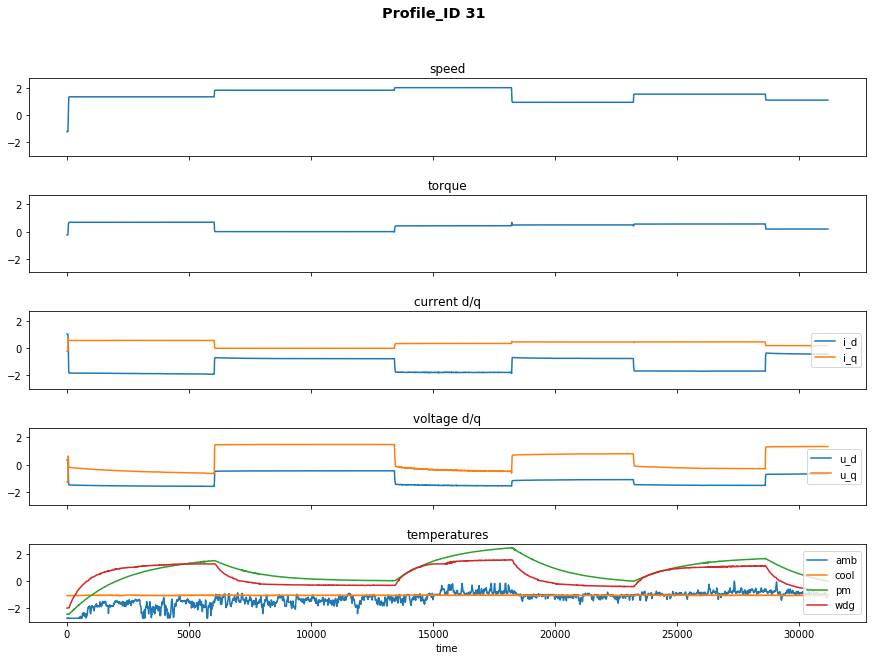

In [4]:
# Visualize load cycles (= profile_id)

# Profile_ID is a unique ID for each measurement.
IDs = np.array(data_df['profile_id'].unique())
print('Profile ID count: ', len(IDs))
print('Unique Profile IDs (= load cycles):\n', IDs)

# Let's visualize a random load cycle
PID = np.random.choice(IDs)
print('Plotting Profile ID: ', PID, '....')
plot_ID(data_df, PID)

In [5]:
# Manually examine all load cycles by saving figures to disk.
    
SaveAllCycles = False
    
if SaveAllCycles:    
    path = os.getcwd()

    if not os.path.exists(path + '/cycles'):
        os.mkdir('/kaggle/working/cycles')

    #for PID in data_df['profile_id'].unique():
    #    plot_ID(data_df, PID, path = '/kaggle/working/cycles')

    myzip = zipfile.ZipFile('/kaggle/working/cycles.zip', 'w')
    for _, _, files in os.walk('/kaggle/working/cycles'):
        [myzip.write('cycles/' + fname) for fname in files]

    print('Saved all figures and created archive.')

Max load profile length: 6.11 h
Min load profile length: 0.30 h


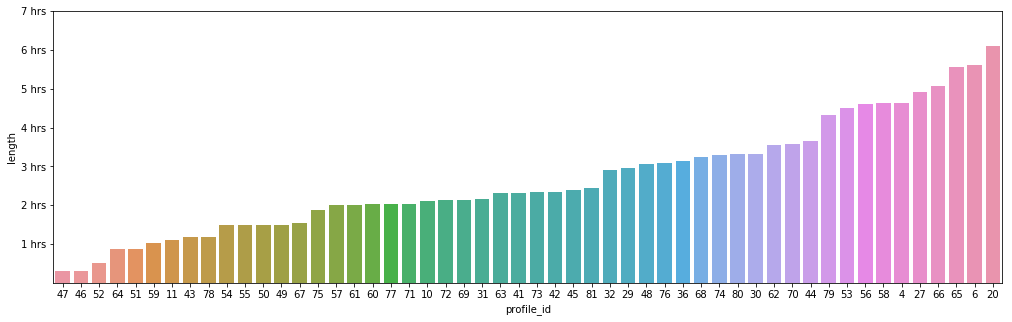

In [6]:
# Visualize load cycle lengths. Depending on the NN architecture, the profiles need to be zero-padded.

plot_ID_len(data_df)

# Feature Engineering and Preprocessing

* Derive additional features.
* Prepare data for training (zero-padding, downsampling, mini-batches).
* Train/Dev/Test-Split.
* Normalization / Scaling.

## Hyperparameters and shared utils for Feature Engineering

In [7]:
# Hyperparameters (downsampling, train/dev/test-split, feature selection, ...)
downsample_rate = 4
n_dev = 2 
n_test = 1
window_len = 64
features = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q', 'u_s', 'i_s', 's_el']
feature_len = len(features)
target = ['stator_winding']

In [8]:
# Creates single sample array of shape (1, T, n)
def get_single_sample(df, n_feat, sample_len, downsample_rate=1):
    
    # Get new length for downsampling
    new_len = int(np.floor((max_len + downsample_rate - 1) / downsample_rate) * downsample_rate)
    
    # Convert df to numpy array of shape (1, T, n)
    arr = df.to_numpy()
    arr = np.expand_dims(arr, axis=0)
    
    # Zero-pad to sample_len at the end of the array
    _arr = np.zeros((1, new_len - np.size(arr, 1), n_feat))
    sample = np.concatenate((arr, _arr), axis=1)
    
    # Get sample_weights (zero-padded elements should have zero weight)
    weights = np.concatenate((np.ones(arr.shape), np.zeros(_arr.shape)), axis=1)
    weights = weights[:,:,0]
    
    # Perform Downsampling
    dwn_sample = []
    dwn_weights = []
    for d in np.arange(1,downsample_rate+1):
        dwn_sample.append(sample[:,(-1+d)::downsample_rate,:])
        dwn_weights.append(weights[:,(-1+d)::downsample_rate])
    
    sample = np.concatenate(dwn_sample, axis=0)
    weights = np.concatenate(dwn_weights, axis=0)
        
    return sample, weights


# Creates windowed mini-batches of shape (m, T_windowed, n) with consistent order of batches. 
# This is necessary for TCNs where window_len should match the receptive field of the TCN.
# It could also be used with stateful LSTMs to implement truncated backprop through time (TBPTT).
def get_windowed_batches(X, weights, Y, window_len):
    
    if window_len >= X.shape[1]:
        raise ValueError('Window length must be less than total batch length.')
    
    # get number of splits and clip data to integer splits 
    # (the "loss" of data is affordable, mostly zero-padded data is cut away)
    T = X.shape[1]
    remainder = np.remainder(X.shape[1],window_len)
    X = X[:,:-remainder,:]
    weights = weights[:,:-remainder]
    Y = Y[:,:-remainder,:]
    n_splits = int(X.shape[1]/window_len)
    
    # split input data accordingly
    X_win = np.split(X, n_splits, axis=1)
    weights_win = np.split(weights, n_splits, axis=1)
    Y_win = np.split(Y, n_splits, axis=1)

    # reshape dimensions
    X_win = np.vstack(X_win)
    weights_win = np.vstack(weights_win)
    Y_win = np.vstack(Y_win)
    
    return X_win, weights_win, Y_win

## Derive additional features, create batches and train/dev/test-split

In [9]:
# Derive additional features: Current and voltage magnitude & electrical apparent power

data_df['u_s'] = np.sqrt(data_df['u_d']**2 + data_df['u_q']**2)
data_df['i_s'] = np.sqrt(data_df['i_d']**2 + data_df['i_q']**2)
data_df['s_el'] = 1.5 * data_df['u_s'] * data_df['i_s']

data_df.head(10)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id,u_s,i_s,s_el
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4,1.338647,1.058521,2.125479
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4,1.338906,1.058453,2.125753
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4,1.343680,1.058390,2.133206
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4,1.343940,1.061958,2.140812
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4,1.345541,1.060869,2.141163
5,-0.762936,-1.116955,0.334901,-1.303017,-1.222429,-0.248197,1.031031,-0.246341,-2.522203,-1.831931,-2.062549,-2.017884,4,1.345367,1.060051,2.139236
6,-0.749228,-1.116170,0.335014,-1.302082,-1.222430,-0.247914,1.030493,-0.246162,-2.522538,-1.833012,-2.062115,-2.017243,4,1.344489,1.059486,2.136701
7,-0.738450,-1.113986,0.336256,-1.305155,-1.222432,-0.248321,1.030107,-0.246035,-2.522844,-1.832182,-2.061953,-2.017213,4,1.347775,1.059082,2.141106
8,-0.730910,-1.111828,0.334905,-1.303790,-1.222432,-0.247785,1.029851,-0.245981,-2.522808,-1.831576,-2.062443,-2.017739,4,1.346117,1.058820,2.137944
9,-0.727130,-1.109486,0.335988,-1.305633,-1.222431,-0.248294,1.029636,-0.245888,-2.522677,-1.831438,-2.062317,-2.018180,4,1.348171,1.058589,2.140739


In [10]:
# Prepare Data for use with LSTMs: Data needs to be in shape (m, T, n)

# get maximum length, select features and target
max_len = data_df.groupby(['profile_id']).size().max()

# Prepare index for faster iteration
iter_df = data_df.copy() # copy increases memory use, but avoids errors when executed twice. Better solution?
iter_df['idx'] = data_df.index
iter_df.set_index(['profile_id', 'idx'], inplace = True)

# create (m, T, n) array for X_values, sample_weights and Y_values
batch_samples_X = []
batch_weights_X = []
batch_samples_Y = []

for pid in IDs:
    # select profile
    df = iter_df.loc[pid]
    # get X samples and weights
    sample, weights = get_single_sample(df[features], 10, max_len, downsample_rate)
    batch_samples_X.append(sample)
    batch_weights_X.append(weights)    
    # get Y samples
    sample, _ = get_single_sample(df[target], 1, max_len, downsample_rate)
    batch_samples_Y.append(sample)
    
X_vals = np.concatenate(batch_samples_X, axis=0)
X_weights = np.concatenate(batch_weights_X, axis=0)
Y_vals = np.concatenate(batch_samples_Y, axis=0)

print('Shape of batches')
print('X_vals:    ', X_vals.shape)
print('X_weights: ', X_weights.shape)
print('Y_vals:    ', Y_vals.shape)

Shape of batches
X_vals:     (208, 10993, 10)
X_weights:  (208, 10993)
Y_vals:     (208, 10993, 1)


In [11]:
# Create train-dev-test-split for LSTMs
# (when cycles are downsampled, all downsampled parts should belong to the same set)
X_train = X_vals[:-(n_dev+n_test)*downsample_rate,:,:]
X_train_weights = X_weights[:-(n_dev+n_test)*downsample_rate,:]
Y_train = Y_vals[:-(n_dev+n_test)*downsample_rate,:,:]

X_dev = X_vals[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:,:]
X_dev_weights = X_weights[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:]
Y_dev = Y_vals[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:,:]

X_test = X_vals[-((n_test)*downsample_rate):,:,:]
X_test_weights = X_weights[-((n_test)*downsample_rate):,:]
Y_test = Y_vals[-((n_test)*downsample_rate):,:,:]

print('Shape of train-test-split')
print('train (X, weights, Y): ', X_train.shape, X_train_weights.shape, Y_train.shape)
print('dev (X, weights, Y):   ', X_dev.shape, X_dev_weights.shape, Y_dev.shape)
print('test (X, weights, Y):  ', X_test.shape, X_test_weights.shape, Y_test.shape)


# Normalization / Scaling 
# >> optional, values are already at a similar scale

# EWMA filtering 
# >> optional, this de-noises the data which helps with learning and prediction
# >> however, real sensor data is also noisy, so the task is harder and more realistic with noise.

Shape of train-test-split
train (X, weights, Y):  (196, 10993, 10) (196, 10993) (196, 10993, 1)
dev (X, weights, Y):    (8, 10993, 10) (8, 10993) (8, 10993, 1)
test (X, weights, Y):   (4, 10993, 10) (4, 10993) (4, 10993, 1)


Shape of windowed mini-batch train-test-split
train (X, weights, Y):  (33516, 64, 10) (33516, 64) (33516, 64, 1)
dev (X, weights, Y):    (1368, 64, 10) (1368, 64) (1368, 64, 1)
test (X, weights, Y):   (684, 64, 10) (684, 64) (684, 64, 1)


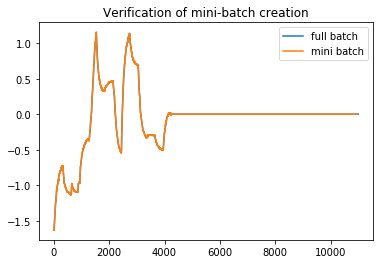

In [12]:
# Data preparation for TCNs is a little different comparted to LSTMs.
# TCNs will use windowed mini-batches that should match the receptive field of the TCN.

X_train_tcn, X_train_weights_tcn, Y_train_tcn = get_windowed_batches(
    X_train, X_train_weights, Y_train, window_len)
X_dev_tcn, X_dev_weights_tcn, Y_dev_tcn = get_windowed_batches(
    X_dev, X_dev_weights, Y_dev, window_len)
X_test_tcn, X_test_weights_tcn, Y_test_tcn = get_windowed_batches(
    X_test, X_test_weights, Y_test, window_len)  

print('Shape of windowed mini-batch train-test-split')
print('train (X, weights, Y): ', X_train_tcn.shape, X_train_weights_tcn.shape, Y_train_tcn.shape)
print('dev (X, weights, Y):   ', X_dev_tcn.shape, X_dev_weights_tcn.shape, Y_dev_tcn.shape)
print('test (X, weights, Y):  ', X_test_tcn.shape, X_test_weights_tcn.shape, Y_test_tcn.shape)

# Get batch_size and verify mini-batches by plotting re-stacked mini-batch
batch_size = X_train.shape[0]
sample_cycle = 49
plt.plot(Y_train[sample_cycle,:,0])
plt.plot(np.concatenate(Y_train_tcn[sample_cycle::batch_size,:,0], axis=0))
plt.legend(['full batch', 'mini batch'])
plt.title('Verification of mini-batch creation');

# Neural Network Training
* LSTM - A simple (sequential) LSTM architecture.
* ResLSTM - LSTM with residual connections.
* TCN - Temporal Convolutional Network with residual connections.

## Hyperparameters and shared utils for model training
To keep things simple the same hyperparameters are used for all models that are being compared (if applicable). The number of units in the LSTM units is equal to the number of filters used for the TCN. Also, the model architecture is kept similar: All models share a final dense network consisting of three layers with descending number of units. For residual networks, two blocks are used for both LSTM and TCN. The same learning and dropout rate is used, however spatial dropout is only applied to TCNs.

In [13]:
n_epochs = 100
lr = 0.01
lr_decay = 1e-2
dropout_rate = 0.1
spatial_dropout = 0.7
n_units = 64
n_dense_in = 32
n_dense_mid = 8
n_dense_out = 1
len_kernel = 4

In [14]:
# Plots the loss over all epochs and a zoom on the last 20 epochs.
def plot_learning_curves(history, descr=' '):

    # get results
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss)) 
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # loss
    axes[0].plot(epochs, loss, 'r')
    axes[0].plot(epochs, val_loss, 'b')
    axes[0].set_title('Loss - Train vs. Validation')
    axes[0].legend(['Train', 'Validation'])
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('loss')
    
    # mse
    axes[1].plot(epochs[n_epochs-20:], loss[n_epochs-20:], 'r')
    axes[1].plot(epochs[n_epochs-20:], val_loss[n_epochs-20:], 'b')
    axes[1].set_title('Loss - Zoom to last 20 epochs')
    axes[1].legend(['Train', 'Validation'])
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('loss')
    axes[1].set_xticks(np.arange(n_epochs-20, n_epochs, step=2))
    
    fig.suptitle(descr, fontsize="x-large", fontweight='bold')
    
    return

## SimpleLSTM
First, let's start with a simple LSTM. There should be about 50k trained parameters. This number is close to the simplest model used in the research paper (though this one here uses no residual connections). According to the research findings it should already reach a descent performance in predicting the electric motor temperature.

In [15]:
simple_lstm = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(n_units, return_sequences=True, input_shape=[None, feature_len]),
  tf.keras.layers.LSTM(n_units, return_sequences=True),
  tf.keras.layers.Dense(n_dense_in, activation="relu"),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(n_dense_mid, activation="relu"),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(n_dense_out),
])

simple_lstm.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr, 
                                     decay=lr_decay,
                                     beta_1=0.9, beta_2=0.999, amsgrad=False)

simple_lstm.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mse'],
              sample_weight_mode='temporal')

print('---- training in progress ----')

history = simple_lstm.fit(x=X_train, y=Y_train, 
                          validation_data=(X_dev, Y_dev, X_dev_weights), 
                          sample_weight=X_train_weights, 
                          epochs=n_epochs,
                          verbose=0)

print('--- done ---')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          19200     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 32)          2080      
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 8)           264       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 8)           0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           9

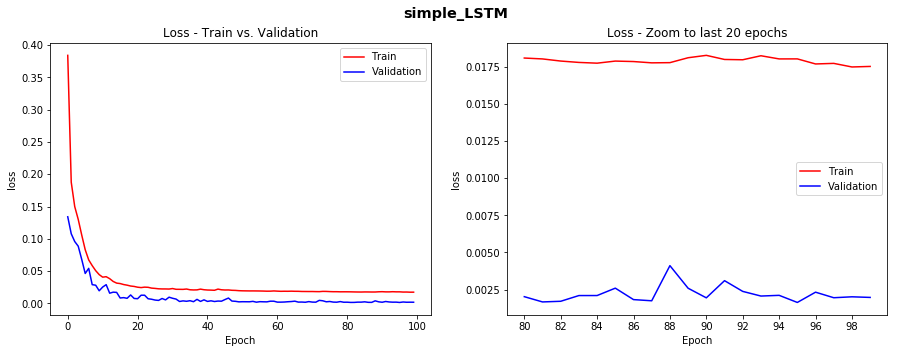

In [16]:
plot_learning_curves(history, descr='simple_LSTM')

## ResLSTM
The ResLSTM adds residual connections to the architecture using keras functional API. The Dense layers and number of nodes of the LSTMs will be the same as the simple_LSTM model. To reduce computational cost, the number of parameters is about 120k where in the original research paper >850k parameters were trained.

In [17]:
inputs = tf.keras.layers.Input(shape=[None, feature_len])

# First residual LSTM block
out_1 = tf.keras.layers.LSTM(n_units, return_sequences=True)(inputs)
out_2 = tf.keras.layers.LSTM(n_units, return_sequences=True)(out_1)
add_1 = tf.keras.layers.Add()([out_1, out_2])

# Second residual LSTM block
out_3 = tf.keras.layers.LSTM(n_units, return_sequences=True)(add_1)
out_4 = tf.keras.layers.LSTM(n_units, return_sequences=True)(out_3)
add_2 = tf.keras.layers.Add()([out_3, out_4])

# Dense Layer
x = tf.keras.layers.Dense(n_dense_in, activation="relu")(add_2)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(n_dense_mid, activation="relu")(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
y = tf.keras.layers.Dense(n_dense_out)(x)

res_lstm = tf.keras.models.Model(inputs=[inputs], outputs=y)

res_lstm.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr, 
                                     decay=lr_decay,
                                     beta_1=0.9, beta_2=0.999, amsgrad=False)

res_lstm.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mse'],
              sample_weight_mode='temporal')

print('---- training in progress ----')

history = res_lstm.fit(x=X_train, y=Y_train, 
                          validation_data=(X_dev, Y_dev, X_dev_weights), 
                          sample_weight=X_train_weights, 
                          epochs=n_epochs,
                          verbose=0)

print('--- done ---')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 64)     19200       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, None, 64)     33024       lstm_2[0][0]                     
__________________________________________________________________________________________________
add (Add)                       (None, None, 64)     0           lstm_2[0][0]                     
                                                                 lstm_3[0][0]                 

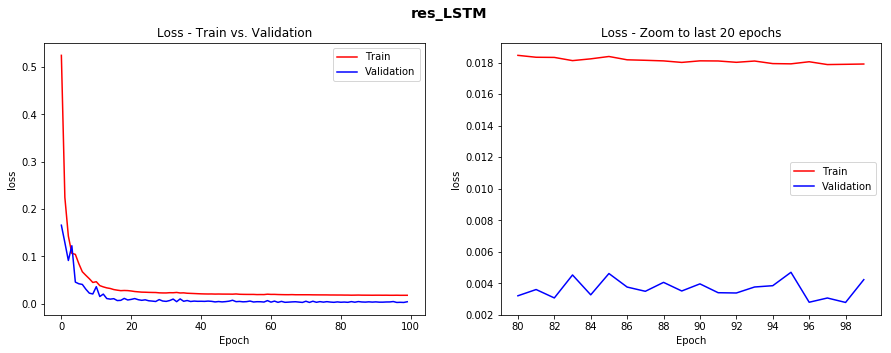

In [18]:
plot_learning_curves(history, descr='res_LSTM')

## Temporal Convolutional Network
TCNs use causual and dilated 1D convolutions for time series prediction. Latest studies show that they have longer memory capabilites than LSTMs and can outperform them in various tasks on both artifical and real datasets - including this temperature estimation task. Here, the TCN has some issues with the dev set, which could be because the dev set contains fairly noisy data and the windowing makes it difficult for the TCN to handle it.

In [19]:
inputs = tf.keras.layers.Input(shape=[None, feature_len])

# First residual TCN block
x_1 = tf.keras.layers.Conv1D(filters=n_units, kernel_size=len_kernel, 
           dilation_rate=1, activation='relu', padding='causal')(inputs)
x_1 = tf.keras.layers.Conv1D(filters=n_units, kernel_size=len_kernel, 
           dilation_rate=2, activation='relu', padding='causal')(x_1)
x_1 = tf.keras.layers.Conv1D(filters=n_units, kernel_size=len_kernel, 
           dilation_rate=4, activation='relu', padding='causal')(x_1)
x_1 = tf.keras.layers.Conv1D(filters=n_units, kernel_size=len_kernel, 
           dilation_rate=8, activation='relu', padding='causal')(x_1)
x_1 = tf.keras.layers.SpatialDropout1D(rate=spatial_dropout)(x_1)
x_1_res = tf.keras.layers.Conv1D(filters=n_units, kernel_size=1, dilation_rate=2, padding='causal')(inputs)
x_1 = tf.keras.layers.Add()([x_1_res, x_1])

# Second residual TCN block
x_2 = tf.keras.layers.Conv1D(filters=n_units, kernel_size=len_kernel, 
           dilation_rate=1, activation='relu', padding='causal')(x_1)
x_2 = tf.keras.layers.Conv1D(filters=n_units, kernel_size=len_kernel, 
           dilation_rate=2, activation='relu', padding='causal')(x_2)
x_2 = tf.keras.layers.Conv1D(filters=n_units, kernel_size=len_kernel, 
           dilation_rate=4, activation='relu', padding='causal')(x_2)
x_2 = tf.keras.layers.Conv1D(filters=n_units, kernel_size=len_kernel, 
           dilation_rate=8, activation='relu', padding='causal')(x_2)
x_2 = tf.keras.layers.SpatialDropout1D(rate=spatial_dropout)(x_2)
x_2_res = tf.keras.layers.Conv1D(filters=n_units, kernel_size=1, dilation_rate=2, padding='causal')(x_1)
x_2 = tf.keras.layers.Add()([x_2_res, x_2])

# Dense Layer
x_3 = tf.keras.layers.Dense(n_dense_in, activation="relu")(x_2)
x_3 = tf.keras.layers.Dropout(dropout_rate)(x_3)
x_3 = tf.keras.layers.Dense(n_dense_mid, activation="relu")(x_3)
x_3 = tf.keras.layers.Dropout(dropout_rate)(x_3)
y = tf.keras.layers.Dense(n_dense_out)(x_3)

TCN = tf.keras.models.Model(inputs=[inputs], outputs=y)

TCN.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr, 
                                     decay=lr_decay,
                                     beta_1=0.9, beta_2=0.999, amsgrad=False)

TCN.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mse'],
              sample_weight_mode='temporal')

print('---- training in progress ----')

history = TCN.fit(x=X_train_tcn, y=Y_train_tcn, 
                          validation_data=(X_dev_tcn, Y_dev_tcn, X_dev_weights_tcn), 
                          sample_weight=X_train_weights_tcn, 
                          epochs=n_epochs,
                          batch_size=batch_size,
                          verbose=0)

print('--- done ---')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 64)     2624        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     16448       conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 64)     16448       conv1d_1[0][0]                   
____________________________________________________________________________________________

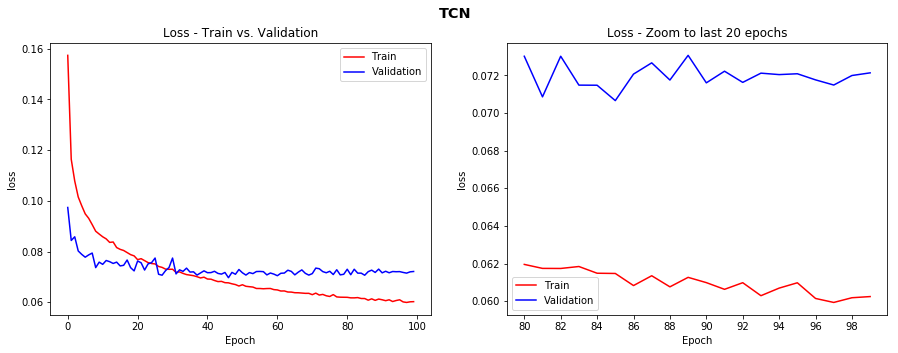

In [20]:
plot_learning_curves(history, descr='TCN')

# Model Evaluation
* Optimizing metric is MSE (mean squared error).
* An arbitrary load cycle from the training set is plotted to show and validate training results.
* The worst load cycle from the dev set is plotted for hyperparameter tuning.

## Shared utils for evaluation

In [21]:
# This function makes a prediction on a given X of shape (1,Tx,1).
# The first skip_values are truncated, because initial temperature states may have large error.
# Also, only "not-zero-padded" part of the sequence is taken into account (-> sample_weight = 1).
def eval_model(model, X, Y, weights, skip_values=10, scaler=None):
    # prepare data for prediction
    end_sequence = np.where(weights==0)[1][0] # get "real" (= not-zero-padded) end of sequence
    X_pred = X[:,:end_sequence,:]
    Y_truth = Y[0,:end_sequence,0]

    # predict (and rescale if necessary)
    Y_pred = model.predict(X_pred)
    if scaler:
        Y_pred = scaler.inverse_transform(Y_pred)     
    Y_pred = Y_pred[0,:,0]
    
    # skip the first few values (large errors due to initialization phase)
    Y_pred = Y_pred[skip_values:]
    Y_truth = Y_truth[skip_values:]
        
    # calculate errors
    abs_error = np.abs(Y_pred-Y_truth)
    mse_error = np.mean(abs_error**2)    
    
    return Y_pred, Y_truth, abs_error, mse_error

# This function outputs a plot showing the prediction vs. ground truth and the corresponding error.
def plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr=' '):

    fig, axes = plt.subplots(1, 2, sharex = True, figsize=(15, 5))

    # Temperature values
    axes[0].plot(Y_truth, 'r')
    axes[0].plot(Y_pred, 'b')
    axes[0].set_title('Prediction vs. ground truth')
    axes[0].legend(['Truth', 'Prediction'])
    axes[0].set_xlabel('sample')
    axes[0].set_ylabel('Temperature')
    
    # Error
    axes[1].plot(abs_error, 'r')
    axes[1].set_title('Error (total MSE: {:.5f})'.format(mse_error))
    axes[1].set_xlabel('sample')
    axes[1].set_ylabel('Error')
    
    fig.suptitle(descr, fontsize="x-large", fontweight='bold')

    return

# This function finds the load cycle with the highest mse.
def get_worst_cycle(model, X, Y, weights):
    
    highest_mse = 0
    worst_pid = 0

    for pid in np.arange(0,X.shape[0]):
        X_pred = X[pid:pid+1,:,:]
        Y_truth = Y[pid:pid+1,:,:]
        X_weights = weights[pid:pid+1,:]
        Y_pred, Y_truth, abs_error, mse_error = eval_model(model, X_pred, Y_truth, X_weights)
        if mse_error > highest_mse:
            highest_mse = mse_error
            worst_pid = pid
    
    return worst_pid

## SimpleLSTM
In accordance to the research paper, a simple model with relatively few parameters can already reach descent accuracy of the temperature estimation.

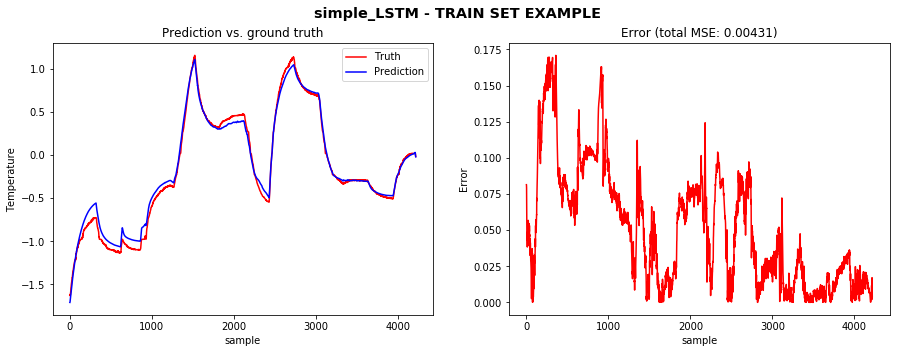

In [22]:
# Plot prediction vs. ground truth for one sample of training set

# training set
pid = 49 # basically a random load cycle
X_pred_train = X_train[pid:pid+1,:,:]
Y_truth_train = Y_train[pid:pid+1,:,:]
weights_train = X_train_weights[pid:pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(simple_lstm, X_pred_train, Y_truth_train, weights_train)
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='simple_LSTM - TRAIN SET EXAMPLE')

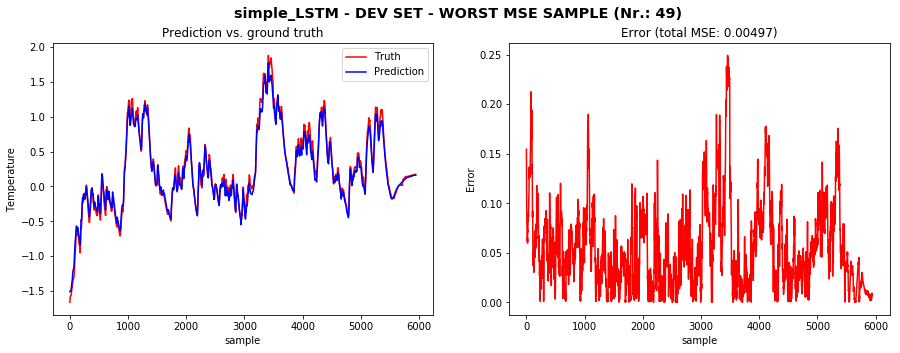

In [23]:
# Plot worst load cycle from dev set (highest mse)

worst_pid = get_worst_cycle(simple_lstm, X_dev, Y_dev, X_dev_weights)

X_pred_dev = X_dev[worst_pid:worst_pid+1,:,:]
Y_truth_dev = Y_dev[worst_pid:worst_pid+1,:,:]
weights_dev = X_dev_weights[worst_pid:worst_pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(simple_lstm, X_pred_dev, Y_truth_dev, weights_dev)        
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='simple_LSTM - DEV SET - WORST MSE SAMPLE (Nr.: ' + str(pid) +')')

## ResLSTM
Adding residual connections and increasing the model complexity also leads to a good temperature estimation. Here, the difference between the simple LSTM and the residual LSTM is not too big.

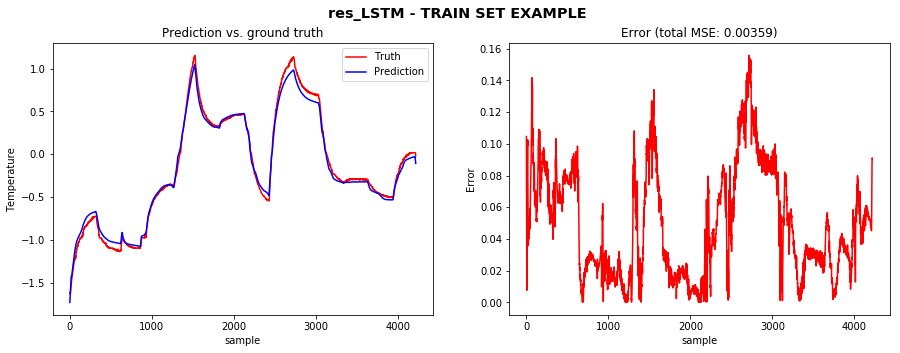

In [24]:
# Plot prediction vs. ground truth for one sample of training set

# training set
pid = 49 # basically a random load cycle
X_pred_train = X_train[pid:pid+1,:,:]
Y_truth_train = Y_train[pid:pid+1,:,:]
weights_train = X_train_weights[pid:pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(res_lstm, X_pred_train, Y_truth_train, weights_train)
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='res_LSTM - TRAIN SET EXAMPLE')

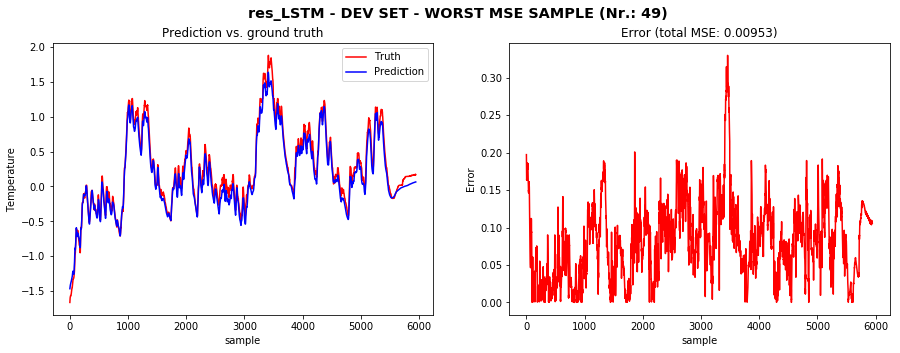

In [25]:
# Plot worst load cycle from dev set (highest mse)

worst_pid = get_worst_cycle(simple_lstm, X_dev, Y_dev, X_dev_weights)

X_pred_dev = X_dev[worst_pid:worst_pid+1,:,:]
Y_truth_dev = Y_dev[worst_pid:worst_pid+1,:,:]
weights_dev = X_dev_weights[worst_pid:worst_pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(res_lstm, X_pred_dev, Y_truth_dev, weights_dev)        
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='res_LSTM - DEV SET - WORST MSE SAMPLE (Nr.: ' + str(pid) +')')

## TCN
With fairly simple hyperparameters, the TCN can only approximate the correct temperature of the elctric motor. So in this notebook the LSTMs outperform the TCN. This is not a general assumption, as the best model of the research paper was a residual TCN. However it might indicate that TCNs need some more attention regarding model architecture and hyperparameter tuning than LSTMs.

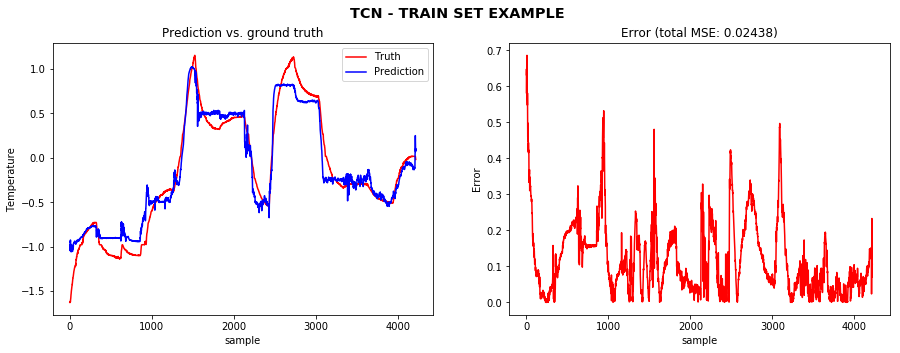

In [26]:
# training set
pid = 49 # basically a random load cycle
X_pred_train = X_train[pid:pid+1,:,:]
Y_truth_train = Y_train[pid:pid+1,:,:]
weights_train = X_train_weights[pid:pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(TCN, X_pred_train, Y_truth_train, weights_train)
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='TCN - TRAIN SET EXAMPLE')

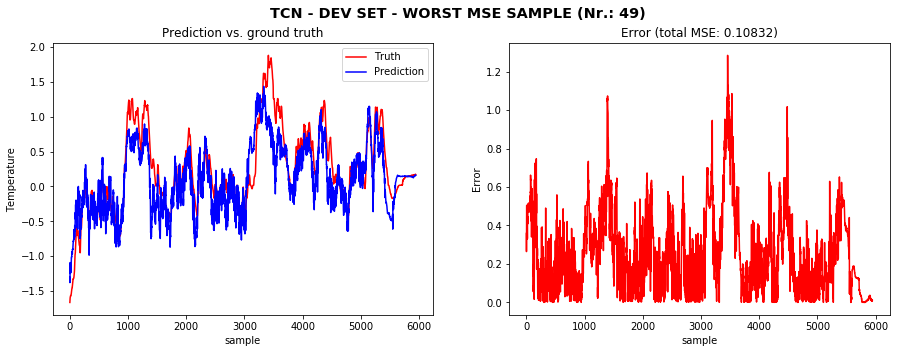

In [27]:
# Plot worst load cycle from dev set (highest mse)

worst_pid = get_worst_cycle(TCN, X_dev, Y_dev, X_dev_weights)

X_pred_dev = X_dev[worst_pid:worst_pid+1,:,:]
Y_truth_dev = Y_dev[worst_pid:worst_pid+1,:,:]
weights_dev = X_dev_weights[worst_pid:worst_pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(TCN, X_pred_dev, Y_truth_dev, weights_dev)        
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='TCN - DEV SET - WORST MSE SAMPLE (Nr.: ' + str(pid) +')')

# Summary
The goal of this notebook was to proof the concept of temperature estimation of electric motors with neural nets. It can be seen that low errors can be reached even without too complicated models or an extensive hyperparameter search. Even the temperature behaviour of highly dynamic load cycles can be mapped appropriately. There are some aspects left out that has been covered in the research paper, so there is room for improvement. For example, training could be even more efficient using "chrono-initialization" of the biases or TBPTT when training LSTMs. Also, the TCN model of this notebook still requires more detailed tuning. Some optimizations might be done in future versions of the notebook.  

The data has been anonymized, so the "real" accuracy can only be estimated. The values of the stator winding temperature ranges from about -2 to 2.5 in the dataset. Assuming that the real temperatures of the test bench recordings range from 20°C room temperature to 180°C maximum operation temperature, 1°C is equal to 0,028. Neural nets can reach state-of-the-art accuracy which varies from 3-5°C accuracy depending on the load cycle dynamics. The temperature estimation in the initial phase of a load cycle has been ignored, because typically the motor does not reach a critical temperature within the first few moments of operation. Of course, for a real application this would have to be considered.